# Skin Cancer Classification Model

This notebook trains a CNN model for skin cancer classification using the ISIC dataset.


In [ ]:
# !pip install kagglehub pandas matplotlib tensorflow scipy


In [1]:
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


/Users/hashdal/Documents/Projects/Personal/aiMedicine/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hashdal/Documents/Projects/Personal/aiMedicine/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [11]:
# Install scipy if not already installed (required for image processing)
import subprocess
import sys

try:
    import scipy
except ImportError:
    print("Installing scipy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    import scipy
    print("scipy installed successfully!")


Installing scipy...
  Using cached scipy-1.16.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached scipy-1.16.3-cp312-cp312-macosx_14_0_arm64.whl (20.9 MB)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


scipy installed successfully!


## 1. Download the Dataset

This dataset is roughly 300-500MB.


In [2]:
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
print("Dataset downloaded to:", path)


Resuming download from 166723584 bytes (657067075 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/nodoubttome/skin-cancer9-classesisic?dataset_version_number=1 (166723584/823790659) bytes left.


100%|██████████| 786M/786M [06:08<00:00, 1.78MB/s]

Extracting files...


Dataset downloaded to: /Users/hashdal/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


## 2. Explore Directory Structure

check what directories exist in the downloaded dataset


In [14]:
# Check what's in the downloaded path
print("Contents of downloaded path:")
print(os.listdir(path))

# The dataset is in a subdirectory
dataset_dir = os.path.join(path, 'Skin cancer ISIC The International Skin Imaging Collaboration')
train_dir = os.path.join(dataset_dir, 'Train')
test_dir = os.path.join(dataset_dir, 'Test')


print(f"\nTrain directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")


Contents of downloaded path:
['Skin cancer ISIC The International Skin Imaging Collaboration']

Train directory exists: True
Test directory exists: True


## 3. Data Preprocessing

Smaller target size for speed


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of training data for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128), 
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


## 4. Model Architecture

We use a custom CNN instead of a heavy pre-trained model for faster results


In [7]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax') # 9 categories of skin diseases
])


/Users/hashdal/Documents/Projects/Personal/aiMedicine/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5. Compile the Model


In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## 6. Train the Model

Only 5 epochs for a quick result


In [12]:
print("Starting training on the lightweight dataset...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5 
)


Starting training on the lightweight dataset...
Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.2479 - loss: 2.1106 - val_accuracy: 0.2883 - val_loss: 1.7782
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.3499 - loss: 1.8110 - val_accuracy: 0.2500 - val_loss: 1.9887
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - accuracy: 0.3783 - loss: 1.7400 - val_accuracy: 0.4122 - val_loss: 1.6640
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - accuracy: 0.4312 - loss: 1.6474 - val_accuracy: 0.4279 - val_loss: 1.6211
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - accuracy: 0.4925 - loss: 1.5586 - val_accuracy: 0.4392 - val_loss: 1.7178


## 7. Visualize Results


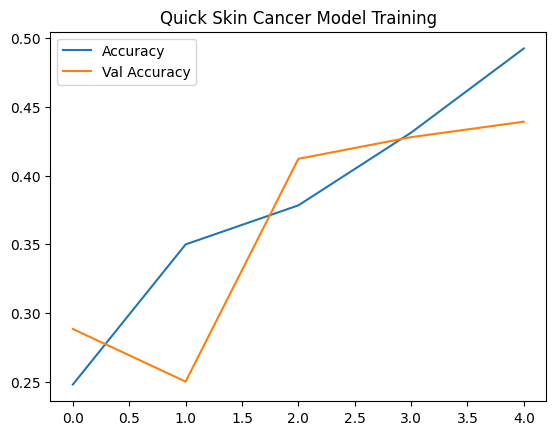

Model training complete.


In [13]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Quick Skin Cancer Model Training')
plt.legend()
plt.show()

print("Model training complete.")


## 8. Save the Model

Save the trained model so it can be used by the Flask API


In [15]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model
model_path = 'models/skin_cancer_model.h5'
model.save(model_path)
print(f"Model saved to {model_path}")
print("You can now use this model with the Flask API!")


Model saved to models/skin_cancer_model.h5
You can now use this model with the Flask API!
